In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from skbio.stats.composition import clr, centralize, alr_inv
from skbio.stats.composition import clr_inv as softmax
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator

from src.generators import ground_truth_edges
from src.evaluate import _edge_roc_curve
from src.util import _roc_curve
from biom import load_table
from scipy.stats import spearmanr, pearsonr
import glob
#import yaml
import datetime
%matplotlib inline

# CF simulation benchmark

In [2]:
results_dir = './results/CF_sims/'
microbes = load_table(os.path.join(results_dir, 'data/table.abs.microbes.0.biom'))
metabolites = load_table(os.path.join(results_dir, 'data/table.abs.metabolites.0.biom'))

In [3]:
mmvec_dir = 'abs/mmvec/'
U = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'U.txt'))
Ubias = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'Ubias.txt'))
V = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'V.txt'))
Vbias = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'Vbias.txt'))

U = np.hstack((np.ones((U.shape[0], 1)), Ubias.reshape(-1, 1), U))
V = np.vstack((Vbias, np.ones((1, V.shape[1])), V))
abs_ranks = pd.DataFrame(clr(alr_inv(U @ V)), index=microbes.ids(axis='observation'),
                         columns=metabolites.ids(axis='observation'))

In [4]:
mmvec_dir = 'rel/mmvec/'
U = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'U.txt'))
Ubias = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'Ubias.txt'))
V = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'V.txt'))
Vbias = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'Vbias.txt'))

U = np.hstack((np.ones((U.shape[0], 1)), Ubias.reshape(-1, 1), U))
V = np.vstack((Vbias, np.ones((1, V.shape[1])), V))
rel_ranks = pd.DataFrame(clr(alr_inv(U @ V)), index=microbes.ids(axis='observation'),
                         columns=metabolites.ids(axis='observation'))
# rel_ranks.to_csv("./results/CF_sims/rel/rel_ranks_mmvec.tsv", sep='\t', index=True)

In [5]:
# create separate ROC curves for each type of interaction
released = [('theta_p', 'I'),
            ('theta_p', 'P'),
            ('theta_f', 'F')]
consumed = [('theta_p', 'SA'),
            ('theta_f', 'SG')]
inhibited = [('theta_f', 'I')]

In [6]:
sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
specificity = lambda x: x['TN'] / (x['TN'] + x['FP'])
precision = lambda x: x['TP'] / (x['TP'] + x['FP'])
recall = lambda x: x['TP'] / (x['TP'] + x['FN'])

In [7]:
#results_dir = '../results/benchmark_output/scale_benchmark/'
#microbes = load_table(os.path.join(results_dir, 'microbe_abs.biom'))
#metabolites = load_table(os.path.join(results_dir, 'metabolite_abs.biom'))

fnames = [
    ['pearson', 'abs_pearson.txt', 'rel_pearson.txt'],
    ['spearman', 'abs_spearman.txt', 'rel_spearman.txt'],
    ['sparcc', 'cor_matrix_abs_SparCC.csv', 'cor_matrix_rel_SparCC.csv'],
    ['phi', 'prop_matrix_abs_PHI.csv', 'prop_matrix_rel_PHI.csv'],
    ['rho', 'prop_matrix_abs_RHO.csv', 'prop_matrix_rel_RHO.csv'],
    ['spiec-easi', 'weights_abs_SPIECEASI.csv', 'weights_rel_SPIECEASI.csv']
]

In [8]:
def plot_scales(tool, abs_file, rel_file, axs):
    microbe_ids = microbes.ids(axis='observation')
    metabolite_ids = metabolites.ids(axis='observation')
    lw = 0.1
    if '.txt' in abs_file or '.txt' in rel_file:
        abs_ranks = pd.read_table(os.path.join(results_dir, 'abs/' + abs_file),
                                  index_col=0).loc[microbe_ids, metabolite_ids]
        rel_ranks = pd.read_table(os.path.join(results_dir, 'rel/' + rel_file),
                                  index_col=0).loc[microbe_ids, metabolite_ids]
    else:
        abs_ranks = pd.read_csv(os.path.join(results_dir, 'abs/' + abs_file),
                                index_col=0).loc[microbe_ids, metabolite_ids]
        rel_ranks = pd.read_csv(os.path.join(results_dir, 'rel/' + rel_file),
                                index_col=0).loc[microbe_ids, metabolite_ids]

    axs.scatter(abs_ranks.values.ravel(), rel_ranks.values.ravel(), linewidth=lw,
                facecolors='none', edgecolors='k', alpha=0.5)

    axs.tick_params(axis="x", labelsize=14)
    axs.tick_params(axis="y", labelsize=14)
    axs.xaxis.set_major_locator(plt.MaxNLocator(4))
    axs.yaxis.set_major_locator(plt.MaxNLocator(4))
    axs.set_title(tool, fontsize=18)
    axs.set_xlabel('Absolute', fontsize=14)
    axs.set_ylabel('Relative', fontsize=14)

Text(0, 0.5, 'Relative')

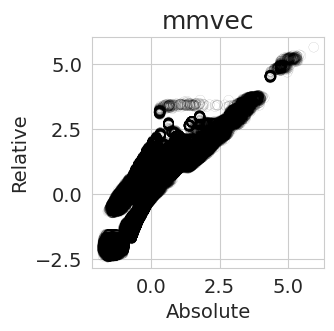

In [10]:
tool = 'mmvec'
fig, axs = plt.subplots(figsize=(3, 3))
axs.scatter(abs_ranks.values.ravel(), rel_ranks.values.ravel(), linewidth=0.1,
            facecolors='none', edgecolors='k', alpha=0.5, s=50)

axs.tick_params(axis="x", labelsize=14)
axs.tick_params(axis="y", labelsize=14)
axs.xaxis.set_major_locator(plt.MaxNLocator(4))
axs.yaxis.set_major_locator(plt.MaxNLocator(4))
axs.set_title(tool, fontsize=18)
axs.set_xlabel('Absolute', fontsize=14)
axs.set_ylabel('Relative', fontsize=14)

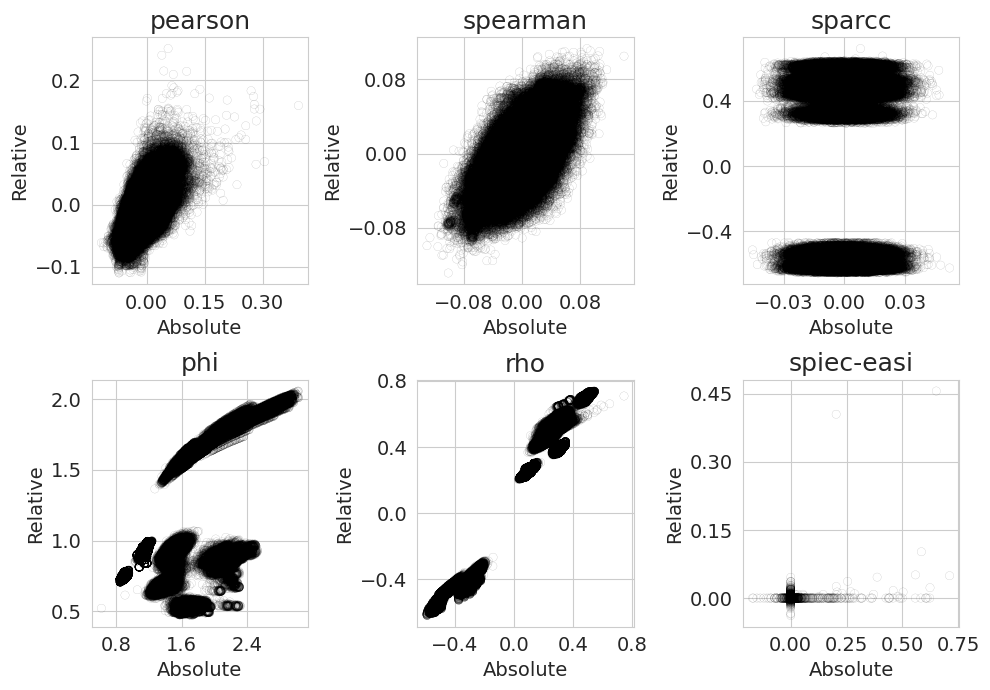

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(10, 7))
for idx, res in enumerate(fnames):
    t, a, r = res
    i, j = idx // 3, idx % 3
    plot_scales(t, a, r, ax[i][j])

plt.tight_layout()

Text(0, 0.5, 'Relative')

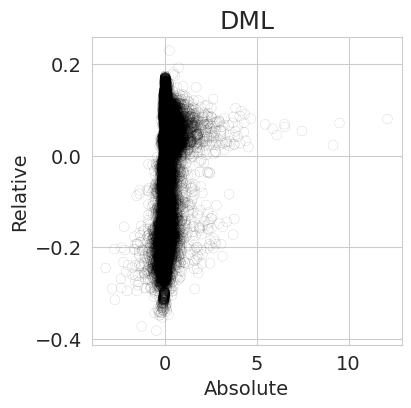

In [9]:
ranks = rel_ranks
dml_abs_ranks = pd.read_csv(os.path.join(results_dir, 'abs/dml_ranks.norm.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]
dml_rel_ranks = pd.read_csv(os.path.join(results_dir, 'rel/dml_ranks.norm.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]

tool = 'DML'
fig, axs = plt.subplots(figsize=(4, 4))
axs.scatter(dml_abs_ranks.values.ravel(), dml_rel_ranks.values.ravel(), linewidth=0.1,
            facecolors='none', edgecolors='k', alpha=0.5, s=50)

axs.tick_params(axis="x", labelsize=14)
axs.tick_params(axis="y", labelsize=14)
axs.xaxis.set_major_locator(plt.MaxNLocator(4))
axs.yaxis.set_major_locator(plt.MaxNLocator(4))
axs.set_title(tool, fontsize=18)
axs.set_xlabel('Absolute', fontsize=14)
axs.set_ylabel('Relative', fontsize=14)

# Precision-Recall curves

In [9]:
ranks = rel_ranks
pearson_ranks = pd.read_table(os.path.join(results_dir, 'rel/rel_pearson.txt'), index_col=0)
spearman_ranks = pd.read_table(os.path.join(results_dir, 'rel/rel_spearman.txt'), index_col=0)
sparcc_ranks = pd.read_csv(os.path.join(results_dir, 'rel/cor_matrix_rel_SparCC.csv'),
                           index_col=0).loc[ranks.index, ranks.columns]
phi_ranks = pd.read_csv(os.path.join(results_dir, 'rel/prop_matrix_rel_PHI.csv'),
                        index_col=0).loc[ranks.index, ranks.columns]
rho_ranks = pd.read_csv(os.path.join(results_dir, 'rel/prop_matrix_rel_RHO.csv'),
                        index_col=0).loc[ranks.index, ranks.columns]
se_ranks = pd.read_csv(os.path.join(results_dir, 'rel/weights_rel_SPIECEASI.csv'),
                       index_col=0).loc[ranks.index, ranks.columns]

# Read DML ranks
dml_results_dir = './results/DML/'

dml_ranks_rf = \
pd.read_csv(os.path.join(dml_results_dir, 'original_data/coefficients.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]
dml_ranks_lr = pd.read_csv(os.path.join(dml_results_dir, 'lr_original_data/coefficients.tsv'), index_col=0, sep="\t").T.loc[ranks.index, ranks.columns]
# dml_ranks_boost = pd.read_csv(os.path.join(dml_results_dir, 'rel/dml_ranks.boost.earlystopping.tsv'), index_col=0, sep="\t").T.loc[ranks.index, ranks.columns]
dml_ranks_xgboost = \
pd.read_csv(os.path.join(dml_results_dir, 'xgboost_original_data/coefficients.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]
# dml_ranks_norm = pd.read_csv(os.path.join(dml_results_dir, 'rel/dml_ranks.norm.tsv'), index_col=0, sep="\t").T.loc[ranks.index, ranks.columns]

dml_ranks_clr_rf = pd.read_csv(os.path.join(dml_results_dir, 'rf_clr/coefficients.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]
dml_ranks_clr_sc_rf = \
pd.read_csv(os.path.join(dml_results_dir, 'rf_clr_sc/coefficients.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]
dml_ranks_clr_min_rf = \
pd.read_csv(os.path.join(dml_results_dir, 'rf_clr_min/coefficients.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]
dml_ranks_clr_sc_min_rf = \
pd.read_csv(os.path.join(dml_results_dir, 'rf_clr_sc_min/coefficients.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]
dml_ranks_clr_sep_rf = \
pd.read_csv(os.path.join(dml_results_dir, 'rf_clr_sep/coefficients.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]
dml_ranks_clr_sep_min_rf = \
pd.read_csv(os.path.join(dml_results_dir, 'rf_clr_sep_min/coefficients.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]

dml_subset20 = pd.read_csv(os.path.join(dml_results_dir, 'subset20/coefficients.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]
dml_subset100 = pd.read_csv(os.path.join(dml_results_dir, 'subset100/coefficients.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]
dml_subset500 = pd.read_csv(os.path.join(dml_results_dir, 'subset500/coefficients.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]

automl_rf_short = \
pd.read_csv(os.path.join(dml_results_dir, 'automl_rf_short/coefficients.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]
automl_rf_short_clr_min = \
pd.read_csv(os.path.join(dml_results_dir, 'automl_rf_short_clr_min/coefficients.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]
automl_xgboost_short = \
pd.read_csv(os.path.join(dml_results_dir, 'automl_xgboost_short/coefficients.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]
automl_xgboost_short_clr_min = \
pd.read_csv(os.path.join(dml_results_dir, 'automl_xgboost_short_clr_min/coefficients.tsv'), index_col=0,
            sep="\t").T.loc[ranks.index, ranks.columns]

In [10]:
edges = pd.read_table(os.path.join(results_dir, 'data/edges.0.txt'), index_col=0)

/tmp/ipykernel_15651/3109896698.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  edges = pd.read_table(os.path.join(results_dir, 'data/edges.0.txt'), index_col=0)


In [11]:
edges.head()

,microbe,metabolite,direction
0,theta_p_0,P_0,R
1,theta_p_0,P_1,R
2,theta_p_0,P_2,R
3,theta_p_0,P_3,R
4,theta_p_0,P_4,R


In [12]:
# k = 100
# mmvec_res = _edge_roc_curve(ranks, edges, k_max=k, axis=1)
# pearson_res = _edge_roc_curve(pearson_ranks, edges, k_max=k, axis=1)
# spearman_res = _edge_roc_curve(spearman_ranks, edges, k_max=k, axis=1)
# sparcc_res = _edge_roc_curve(sparcc_ranks, edges, k_max=k, axis=1)
# phi_res = _edge_roc_curve(1 / phi_ranks, edges, k_max=k, axis=1)
# rho_res = _edge_roc_curve(rho_ranks, edges, k_max=k, axis=1)
# se_res = _edge_roc_curve(se_ranks, edges, k_max=k, axis=1)

# dml_rf = _edge_roc_curve(dml_ranks_rf, edges, k_max=k, axis=1)
# dml_lr = _edge_roc_curve(dml_ranks_lr, edges, k_max=k, axis=1)
# dml_boost = _edge_roc_curve(dml_ranks_boost, edges, k_max=k, axis=1)
# dml_norm_res = _edge_roc_curve(dml_ranks_norm, edges, k_max=k, axis=1)
# dml_clr_rf_res = _edge_roc_curve(dml_ranks_clr_rf, edges, k_max=k, axis=1)
# dml_clr_scaled_rf_res = _edge_roc_curve(dml_ranks_clr_sc_rf, edges, k_max=k, axis=1)
# dml_clr_min_rf_res = _edge_roc_curve(dml_ranks_clr_min_rf, edges, k_max=k, axis=1)
# dml_clr_sc_min_rf_res = _edge_roc_curve(dml_ranks_clr_sc_min_rf, edges, k_max=k, axis=1)
# dml_clr_sep_rf_res = _edge_roc_curve(dml_ranks_clr_sep_rf, edges, k_max=k, axis=1)
# dml_clr_sep_min_rf_res = _edge_roc_curve(dml_ranks_clr_sep_min_rf, edges, k_max=k, axis=1)
# subset20_res = _edge_roc_curve(dml_subset20, edges, k_max=k, axis=1)
# subset100_res = _edge_roc_curve(dml_subset100, edges, k_max=k, axis=1)
# subset500_res = _edge_roc_curve(dml_subset500, edges, k_max=k, axis=1)



In [13]:
k = 100
mmvec_res = _roc_curve('mmvec', ranks, edges, k_max=k, axis=1)
pearson_res = _roc_curve('pearson', pearson_ranks, edges, k_max=k, axis=1)
spearman_res = _roc_curve('spearman', spearman_ranks, edges, k_max=k, axis=1)
sparcc_res = _roc_curve('sparcc', sparcc_ranks, edges, k_max=k, axis=1)
phi_res = _roc_curve('phi', 1 / phi_ranks, edges, k_max=k, axis=1)
rho_res = _roc_curve('rho', rho_ranks, edges, k_max=k, axis=1)
se_res = _roc_curve('se', se_ranks, edges, k_max=k, axis=1)

dml_rf_res = _roc_curve('dml_rf', dml_ranks_rf, edges, k_max=k, axis=1)
dml_lr_res = _roc_curve('dml_lr', dml_ranks_lr, edges, k_max=k, axis=1)
# dml_boost_res = _roc_curve('dml_boost', dml_ranks_boost, edges, k_max=k, axis=1)
dml_xgboost_res = _roc_curve('dml_xgboost', dml_ranks_xgboost, edges, k_max=k, axis=1)
# dml_norm_res = _roc_curve('dml_norm', dml_ranks_norm, edges, k_max=k, axis=1)

dml_clr_rf_res = _roc_curve('dml_clr_rf', dml_ranks_clr_rf, edges, k_max=k, axis=1)
dml_clr_scaled_rf_res = _roc_curve('dml_clr_sc_rf', dml_ranks_clr_sc_rf, edges, k_max=k, axis=1)
dml_clr_min_rf_res = _roc_curve('dml_clr_min_rf', dml_ranks_clr_min_rf, edges, k_max=k, axis=1)
dml_clr_sc_min_rf_res = _roc_curve('dml_clr_sc_min_rf', dml_ranks_clr_sc_min_rf, edges, k_max=k, axis=1)
dml_clr_sep_rf_res = _roc_curve('dml_clr_sep_rf', dml_ranks_clr_sep_rf, edges, k_max=k, axis=1)
dml_clr_sep_min_rf_res = _roc_curve('dml_clr_sep_min_rf', dml_ranks_clr_sep_min_rf, edges, k_max=k, axis=1)

subset20_res = _roc_curve('dml_subset20_rf', dml_subset20, edges, k_max=k, axis=1)
subset100_res = _roc_curve('dml_subset100_rf', dml_subset100, edges, k_max=k, axis=1)
subset500_res = _roc_curve('dml_subset500_rf', dml_subset500, edges, k_max=k, axis=1)

automl_rf_short_res = _roc_curve('automl_rf_short', automl_rf_short, edges, k_max=k, axis=1)
automl_rf_short_clr_min_res = _roc_curve('automl_rf_short_clr_min', automl_rf_short_clr_min, edges, k_max=k, axis=1)
automl_xgboost_short_res = _roc_curve('automl_xgboost_short', automl_xgboost_short, edges, k_max=k, axis=1)
automl_xgboost_short_clr_min_res = _roc_curve('automl_xgboost_short_clr_min', automl_xgboost_short_clr_min, edges, k_max=k, axis=1)

In [14]:
se_res

[       TP      TN     FP     FN
 1      35  249635    365  29965
 2     147  249347    653  29853
 3     256  249056    944  29744
 4     361  248761   1239  29639
 5     464  248464   1536  29536
 ..    ...     ...    ...    ...
 96   6402  218002  31998  23598
 97   6402  217602  32398  23598
 98   6402  217202  32798  23598
 99   6402  216802  33198  23598
 100  6402  216402  33598  23598
 
 [100 rows x 4 columns],
        TP      TN     FP     FN
 1      14  259614    386  19986
 2      25  259225    775  19975
 3      34  258834   1166  19966
 4      41  258441   1559  19959
 5      46  258046   1954  19954
 ..    ...     ...    ...    ...
 96    831  222431  37569  19169
 97    931  222131  37869  19069
 98   1031  221831  38169  18969
 99   1131  221531  38469  18869
 100  1231  221231  38769  18769
 
 [100 rows x 4 columns],
        TP      TN     FP     FN
 1       0  269600    400  10000
 2      88  269288    712   9912
 3     176  268976   1024   9824
 4     267  268667   1

In [15]:
sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
specificity = lambda x: x['TN'] / (x['TN'] + x['FP'])
precision = lambda x: x['TP'] / (x['TP'] + x['FP'])
recall = lambda x: x['TP'] / (x['TP'] + x['FN'])
f1 = lambda x: 2 * x['precision'] * x['recall'] / (x['precision'] + x['recall'])

In [16]:
for res in (mmvec_res,
            pearson_res, spearman_res, sparcc_res, phi_res, rho_res, se_res,
            dml_rf_res,
            # dml_norm_res,
            dml_lr_res, dml_xgboost_res,
            subset20_res, subset100_res, subset500_res,
            dml_clr_rf_res, dml_clr_scaled_rf_res, dml_clr_min_rf_res, dml_clr_sc_min_rf_res,
            dml_clr_sep_rf_res, dml_clr_sep_min_rf_res,
            automl_rf_short_res, automl_rf_short_clr_min_res, automl_xgboost_short_res, automl_xgboost_short_clr_min_res,
            ):
    for df in res:
        df['TPR'] = df.apply(sensitivity, axis=1)
        df['TNR'] = df.apply(specificity, axis=1)
        df['precision'] = df.apply(precision, axis=1)
        df['recall'] = df.apply(recall, axis=1)
        df['f1_score'] = df.apply(f1, axis=1)

/tmp/ipykernel_15651/1052544215.py:5: RuntimeWarning: invalid value encountered in double_scalars
  f1 = lambda x: 2 * x['precision'] * x['recall'] / (x['precision'] + x['recall'])
/tmp/ipykernel_15651/1052544215.py:5: RuntimeWarning: invalid value encountered in double_scalars
  f1 = lambda x: 2 * x['precision'] * x['recall'] / (x['precision'] + x['recall'])
/tmp/ipykernel_15651/1052544215.py:5: RuntimeWarning: invalid value encountered in double_scalars
  f1 = lambda x: 2 * x['precision'] * x['recall'] / (x['precision'] + x['recall'])
/tmp/ipykernel_15651/1052544215.py:5: RuntimeWarning: invalid value encountered in double_scalars
  f1 = lambda x: 2 * x['precision'] * x['recall'] / (x['precision'] + x['recall'])
/tmp/ipykernel_15651/1052544215.py:5: RuntimeWarning: invalid value encountered in double_scalars
  f1 = lambda x: 2 * x['precision'] * x['recall'] / (x['precision'] + x['recall'])
/tmp/ipykernel_15651/1052544215.py:5: RuntimeWarning: invalid value encountered in double_scala

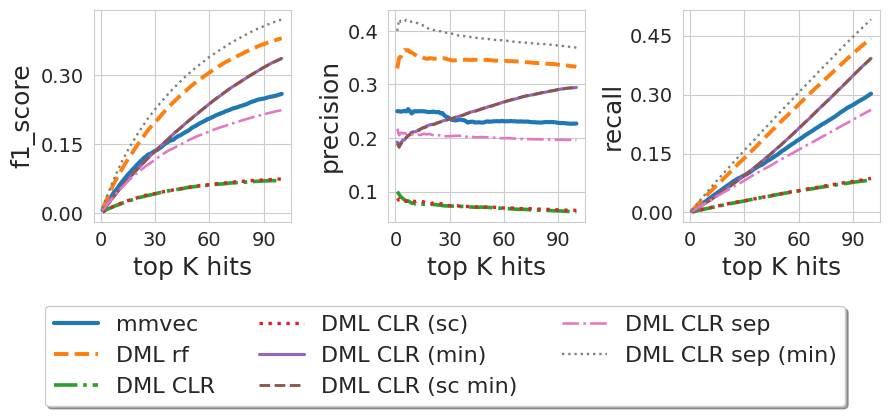

In [19]:
def plot_stats(ax, attr='F score', edge_dir=0):
    # ax.plot(mmvec_res[edge_dir][attr], 'k.', label='mmvec')
    # ax.plot(pearson_res[edge_dir][attr], label='spearman')
    # ax.plot(spearman_res[edge_dir][attr], label='pearson')
    # ax.plot(sparcc_res[edge_dir][attr], label='sparcc')
    # ax.plot(phi_res[edge_dir][attr], label='phi')
    # ax.plot(rho_res[edge_dir][attr], label='rho')
    # ax.plot(se_res[edge_dir][attr], label='spiec-easi')

    # ax.plot(dml_rf[edge_dir][attr], label='DML rf')
    # ax.plot(dml_norm_res[edge_dir][attr], label='DML norm')
    # ax.plot(dml_clr_rf_res[edge_dir][attr], label='DML clr')
    # ax.plot(dml_clr_scaled_rf_res[edge_dir][attr], label='DML clr (sc)')
    # ax.plot(dml_clr_min_rf_res[edge_dir][attr], label='DML clr (min)')
    # ax.plot(dml_clr_sc_min_rf_res[edge_dir][attr], label='DML clr (sc min)')
    # ax.plot(dml_clr_sep_rf_res[edge_dir][attr], label='DML clr (sep)')
    # ax.plot(dml_clr_sep_min_rf_res[edge_dir][attr], label='DML clr (sep min)')
    # ax.plot(subset20_res[edge_dir][attr], label='DML subset20')
    # ax.plot(subset100_res[edge_dir][attr], label='DML subset100')
    # ax.plot(subset500_res[edge_dir][attr], label='DML subset500')
    # ax.plot(dml_lr[edge_dir][attr], label='DML lr')
    # ax.plot(dml_boost[edge_dir][attr], label='DML boost')
    methods_res = [
        ('mmvec', mmvec_res),
        # ('pearson', pearson_res),
        # ('spearman', spearman_res),
        # ('sparcc', sparcc_res),
        # ('phi', phi_res),
        # ('rho', rho_res),
        # ('se', se_res),

        ('DML rf', dml_rf_res),

        ('DML CLR', dml_clr_rf_res),
        ('DML CLR (sc)', dml_clr_scaled_rf_res),
        ('DML CLR (min)', dml_clr_min_rf_res),
        ('DML CLR (sc min)', dml_clr_sc_min_rf_res),
        ('DML CLR sep', dml_clr_sep_rf_res),
        ('DML CLR sep (min)', dml_clr_sep_min_rf_res),

        # ('DML subset 20', subset20_res),
        # ('DML subset 100', subset100_res),
        # ('DML subset 500', subset500_res),

        # ('DML automl rf', automl_rf_short_res),
        # ('DML automl rf clr(min)', automl_rf_short_clr_min_res),
        # ('DML automl xgboost', automl_xgboost_short_res),
        # ('DML automl xgboost clr(min)', automl_xgboost_short_clr_min_res),

    ]

    for i, (name, df) in enumerate(methods_res):
        lw = 3 - 1.5 * i / len(methods_res)
        ls = ['-', '--', '-.', ':'][i % 4]
        ax.plot(df[edge_dir][attr], label=name, linestyle=ls, linewidth=lw)

    ax.set_ylabel(attr, fontsize=18)
    ax.set_xlabel('top K hits', fontsize=18)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))


fig, ax = plt.subplots(1, 3, figsize=(9, 3))

edge_dir = 0  # for released
# edge_dir = 1  # for consumed
# edge_dir = 2 # for inhibited

plot_stats(ax[0], attr='f1_score', edge_dir=edge_dir)
plot_stats(ax[1], attr='precision', edge_dir=edge_dir)
plot_stats(ax[2], attr='recall', edge_dir=edge_dir)
# ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 2), fontsize=14, shadow=True, fancybox=True)

lines_labels = [ax[1].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=3, fontsize=16)

plt.tight_layout()

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
plt.savefig(f"./figures/sim_{timestamp}.png", bbox_inches='tight')

In [46]:
lines_labels

[([<matplotlib.lines.Line2D at 0x7f2f462f64d0>,
  ['mmvec', 'pearson', 'spearman', 'sparcc', 'phi', 'rho', 'se']),
 ([<matplotlib.lines.Line2D at 0x7f2f46579b90>,
  ['mmvec', 'pearson', 'spearman', 'sparcc', 'phi', 'rho', 'se']),
 ([<matplotlib.lines.Line2D at 0x7f2f46895790>,
  ['mmvec', 'pearson', 'spearman', 'sparcc', 'phi', 'rho', 'se'])]

In [20]:
rho_res

(     TP      TN     FP     FN  TPR     TNR  precision  recall  f1_score
 1     0  249600    400  30000  0.0  0.9984        0.0     0.0       NaN
 2     0  249200    800  30000  0.0  0.9968        0.0     0.0       NaN
 3     0  248800   1200  30000  0.0  0.9952        0.0     0.0       NaN
 4     0  248400   1600  30000  0.0  0.9936        0.0     0.0       NaN
 5     0  248000   2000  30000  0.0  0.9920        0.0     0.0       NaN
 ..   ..     ...    ...    ...  ...     ...        ...     ...       ...
 96    0  211600  38400  30000  0.0  0.8464        0.0     0.0       NaN
 97    0  211200  38800  30000  0.0  0.8448        0.0     0.0       NaN
 98    0  210800  39200  30000  0.0  0.8432        0.0     0.0       NaN
 99    0  210400  39600  30000  0.0  0.8416        0.0     0.0       NaN
 100   0  210000  40000  30000  0.0  0.8400        0.0     0.0       NaN
 
 [100 rows x 9 columns],
      TP      TN     FP     FN  TPR       TNR  precision  recall  f1_score
 1     0  259600    40

In [39]:
sranks = pd.DataFrame(
    list(ranks.apply(
        lambda x: list(ranks.columns[np.argsort(x)]), axis=1)
    )
)
sranks.index = ranks.index

sranks

,0,1,2,3,4,5,6,7,8,9,...,690,691,692,693,694,695,696,697,698,699
theta_p_0,noise_ms_197,noise_ms_171,noise_ms_195,noise_ms_140,noise_ms_185,noise_ms_110,noise_ms_129,noise_ms_134,noise_ms_50,noise_ms_61,...,F_21,F_31,P_0,P_48,F_14,P_14,P_40,F_40,P_19,P_49
theta_p_1,noise_ms_197,noise_ms_20,noise_ms_195,noise_ms_185,noise_ms_140,noise_ms_112,noise_ms_99,noise_ms_32,noise_ms_134,noise_ms_129,...,P_75,F_21,P_0,F_40,F_14,P_48,P_14,P_40,P_19,P_49
theta_p_2,noise_ms_197,noise_ms_195,noise_ms_20,noise_ms_185,noise_ms_129,noise_ms_140,noise_ms_112,noise_ms_171,noise_ms_63,noise_ms_99,...,P_75,F_21,P_0,F_14,P_48,F_40,P_40,P_14,P_19,P_49
theta_p_3,noise_ms_197,noise_ms_195,noise_ms_20,noise_ms_185,noise_ms_129,noise_ms_140,noise_ms_112,noise_ms_99,noise_ms_32,noise_ms_134,...,P_75,F_21,P_0,F_14,P_48,F_40,P_14,P_40,P_19,P_49
theta_p_4,noise_ms_197,noise_ms_195,noise_ms_129,noise_ms_20,noise_ms_185,noise_ms_140,noise_ms_112,noise_ms_63,noise_ms_171,noise_ms_86,...,P_75,F_21,P_0,F_14,P_48,F_40,P_40,P_14,P_19,P_49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
noise_otu_195,noise_ms_197,noise_ms_185,noise_ms_195,noise_ms_99,noise_ms_171,noise_ms_63,noise_ms_137,noise_ms_21,noise_ms_134,noise_ms_140,...,P_75,SG_30,P_0,F_14,P_48,F_40,P_14,P_40,P_19,P_49
noise_otu_196,noise_ms_195,noise_ms_197,noise_ms_185,noise_ms_99,noise_ms_63,noise_ms_171,noise_ms_134,noise_ms_140,noise_ms_21,noise_ms_137,...,SG_30,P_75,F_14,P_48,P_0,F_40,P_14,P_40,P_19,P_49
noise_otu_197,noise_ms_195,noise_ms_185,noise_ms_197,noise_ms_99,noise_ms_63,noise_ms_21,noise_ms_137,noise_ms_134,noise_ms_196,noise_ms_171,...,P_75,SG_30,F_14,P_0,P_48,F_40,P_14,P_40,P_19,P_49
noise_otu_198,noise_ms_197,noise_ms_195,noise_ms_185,noise_ms_171,noise_ms_63,noise_ms_140,noise_ms_134,noise_ms_99,noise_ms_20,noise_ms_196,...,F_31,P_75,F_14,P_48,P_0,F_40,P_40,P_14,P_19,P_49
